# Interpolation of BDT scores
- For each inside mass (i.e. all masses but 200 GeV, 2 TeV) we calculated the mass parameterised BDT score (training with N-1 masses) and get the combined pdf(BDT score, mass) and compare those

# Standard imports

In [2]:
import sklearn
print(sklearn.__version__)
import numpy as np
print("numpy-version: "+np.__version__)
import scipy as sp
print("scipy-version: "+sp.__version__)
!python --version

0.20.3
numpy-version: 1.14.2
scipy-version: 1.1.0
Python 3.6.5


In [3]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [4]:
df_mc=pd.read_hdf('/eos/user/j/jglatzer/L2Output_R20_Nov_v2_pandaspython3/pandas_INC_ge6jge4b.h5', 'INC_ge6jge4b')
df_mc=df_mc[df_mc.process.apply(lambda x: True if "Hp" in x else False)]

# Use the mass parameterised BDT score trained at all masses

In [5]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]

In [6]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc)

First calculate the BDT scores at all masses with the BDTs trained at each of the masses

In [9]:
from joblib import load
clf=load('massparameterisedBDT.joblib')
X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass="multi", addMass=True, invertsignal=False, absoluteWeight=False)

realmass_train=X_train.hpmass.copy()
realmass_test=X_test.hpmass.copy()

frames_train=[]
frames_test=[]
for hpmass in hpmasses:
    X_train.hpmass=hpmass
    decfunc=clf.decision_function(X_train)
    train_decfunc_tmp=pd.concat([realmass_train,X_train.hpmass,pd.Series(decfunc, index=X_train.index), w_train],axis=1)
    train_decfunc_tmp.columns = ['realmass','bdttrainmass', 'decfunc','weight']
    frames_train.append(train_decfunc_tmp)

    
    X_test.hpmass=hpmass
    decfunc=clf.decision_function(X_test)
    test_decfunc_tmp=pd.concat([realmass_test, X_test.hpmass,pd.Series(decfunc, index=X_test.index), w_test],axis=1)
    test_decfunc_tmp.columns = ['realmass','bdttrainmass', 'decfunc','weight']
    frames_test.append(test_decfunc_tmp)
    
    #print(hpmass, train_decfunc_tmp.shape,test_decfunc_tmp.shape)
    
train_decfunc=pd.concat(frames_train, axis=0,ignore_index=True)
test_decfunc=pd.concat(frames_test, axis=0,ignore_index=True)
#print(train_decfunc.shape,test_decfunc.shape)
#train_decfunc.head()
#train_decfunc_tmp.head()

## first plot a histogram of all distributions

We do this just to get an idea how the distributions look

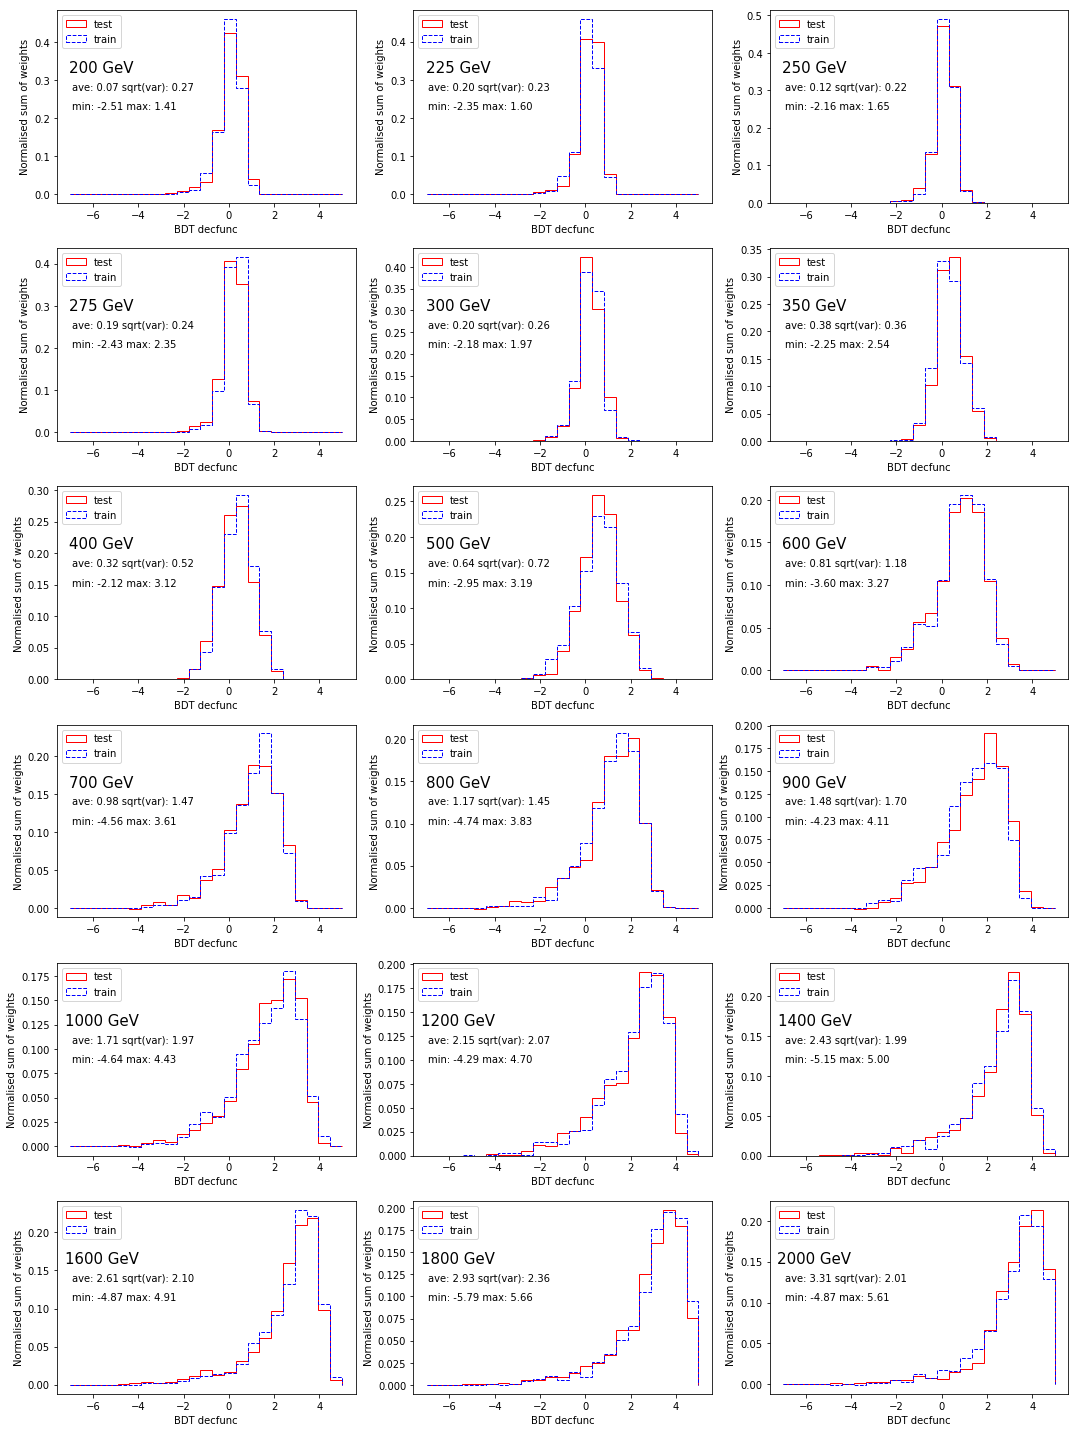

In [10]:
fig, axes=plt.subplots(6,3, figsize=(15, 20))
bins=np.linspace(-10,0,11)

averages=[]
variances=[]
minimums=[]
maximums=[]

for i,hpmass in enumerate(hpmasses):
    axis=axes[i//3][i%3]
    bins=np.linspace(-7,5,24)
    testmask=(test_decfunc.realmass==hpmass) & (test_decfunc.bdttrainmass==hpmass)
    trainmask=(train_decfunc.realmass==hpmass) & (test_decfunc.bdttrainmass==hpmass)
      
    test_weights=test_decfunc[testmask].weight/np.sum(test_decfunc[testmask].weight)
    train_weights=train_decfunc[trainmask].weight/np.sum(train_decfunc[trainmask].weight)
    
        
    axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",density=0,color="r", fill=False, linewidth=1, weights=test_weights.values)
    axis.hist(train_decfunc[trainmask].decfunc.values, bins=bins, ls='--', histtype = 'step',label="train",density=0,color="b", fill=False, linewidth=1, weights=train_weights.values)
    
    axis.legend(loc=2)
    axis.set_xlabel("BDT decfunc")
    axis.set_ylabel("Normalised sum of weights")
    axis.text(0.15, 0.7, str(hpmass)+" GeV",transform=axis.transAxes, ha="center", va="center", rotation=0, size=15)
    ave=np.average(test_decfunc[testmask].decfunc.values, weights=test_weights.values)
    averages.append(ave)
    var=HpMLUtils.variance(test_decfunc[testmask].decfunc.values, weights=test_weights.values)
    variances.append(np.sqrt(var))
    vmin=np.min(test_decfunc[testmask].decfunc.values)
    minimums.append(vmin)
    vmax=np.max(test_decfunc[testmask].decfunc.values)
    maximums.append(vmax)
    label=('ave: {:.2f} sqrt(var): {:.2f}').format(ave,var)
    label2=('min: {:.2f} max: {:.2f}').format(vmin,vmax)
    axis.text(0.05, 0.6, label,transform=axis.transAxes, ha="left", va="center", rotation=0, size=10)
    axis.text(0.05, 0.5, label2,transform=axis.transAxes, ha="left", va="center", rotation=0, size=10)

plt.tight_layout()

Text(0.5,0,'H+ mass [GeV]')

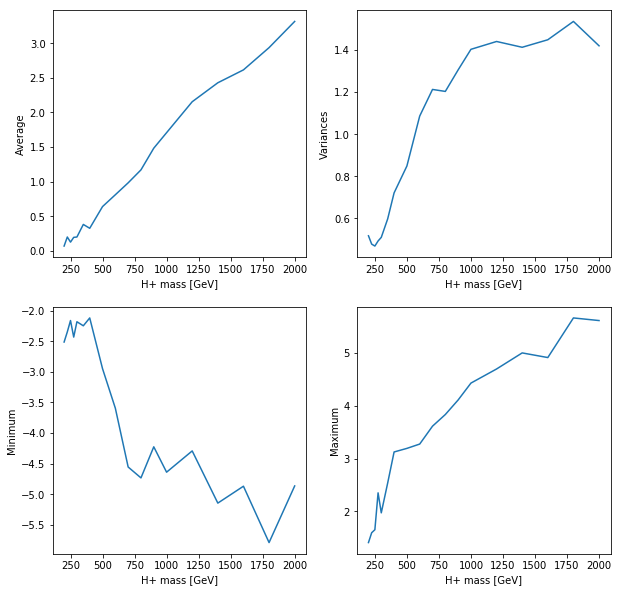

In [11]:
fig, axes=plt.subplots(2,2, figsize=(10, 10))
axes[0][0].plot(hpmasses, averages)
axes[0][0].set_ylabel("Average")
axes[0][0].set_xlabel("H+ mass [GeV]")
axes[0][1].plot(hpmasses, variances)
axes[0][1].set_ylabel("Variances")
axes[0][1].set_xlabel("H+ mass [GeV]")

axes[1][0].plot(hpmasses, minimums)
axes[1][0].set_ylabel("Minimum")
axes[1][0].set_xlabel("H+ mass [GeV]")
axes[1][1].plot(hpmasses, maximums)
axes[1][1].set_ylabel("Maximum")
axes[1][1].set_xlabel("H+ mass [GeV]")

## now let's use a KDE to estimate the PDF for the BDT score distribution

We are first not doing any interpolation, but first checking which functional form and which bandwidth are a good choice

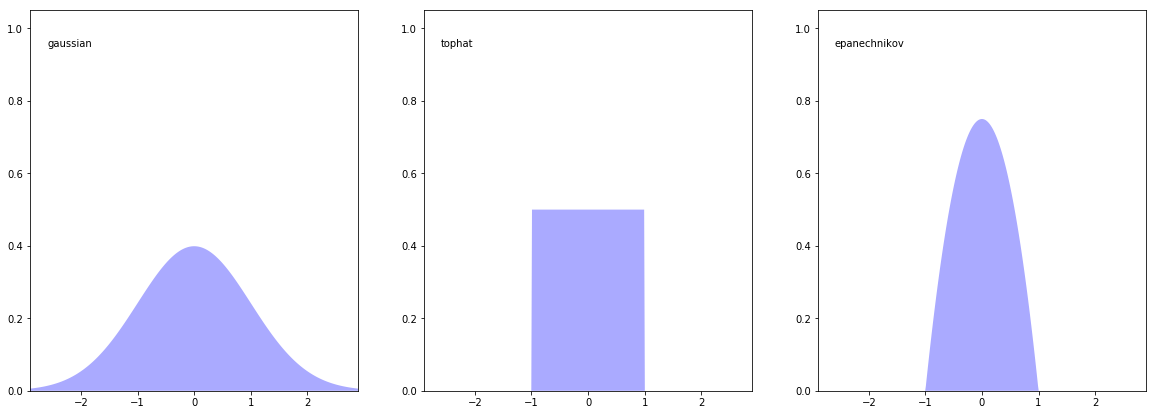

In [12]:
from sklearn.neighbors import KernelDensity
fig, axes=plt.subplots(1,3, figsize=(20, 7))
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))
for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov']):
    axi = axes.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

### first in 1D

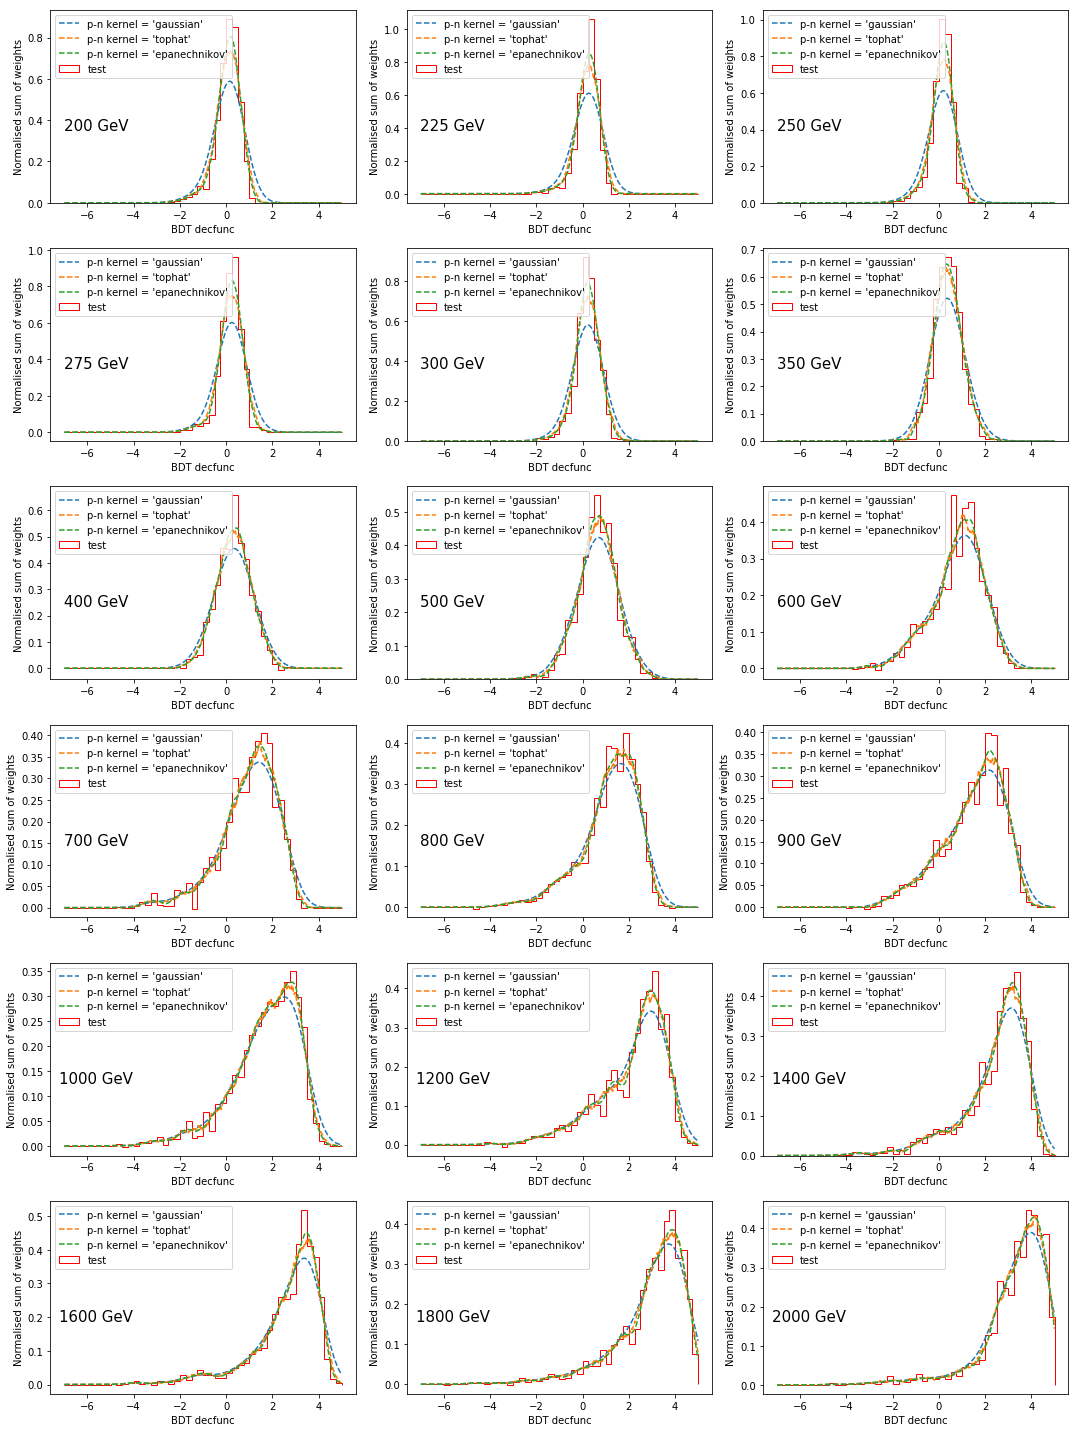

In [13]:
from sklearn.neighbors import KernelDensity
fig, axes=plt.subplots(6,3, figsize=(15, 20))
bins=np.linspace(-7,5,49)
plotx=np.linspace(-6.995,4.995,1200)

for i,hpmass in enumerate(hpmasses):
    axis=axes[i//3][i%3]

    #binned test dataset
    testmask=(test_decfunc.realmass==hpmass) & (test_decfunc.bdttrainmass==hpmass)
    axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",density=1,color="r", fill=False, linewidth=1, weights=test_decfunc[testmask].weight.values)
    
    for kernel in ['gaussian', 'tophat', 'epanechnikov']:
        bandwidth=0.5
        #fit positive and negative weights independently
        kdepos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        pos_test_weights=test_decfunc[testmask & (test_decfunc.weight>0)].weight
        pos_test_values=test_decfunc[testmask & (test_decfunc.weight>0)].decfunc
        kdepos.fit(pos_test_values[:, np.newaxis],y=None,sample_weight=pos_test_weights.values)
        pos_dens = np.exp(kdepos.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, pos_dens, ':', label="kernel = '{0}'".format(kernel))

        kdeneg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        neg_test_weights=abs(test_decfunc[testmask & (test_decfunc.weight<0)].weight)
        neg_test_values=test_decfunc[testmask & (test_decfunc.weight<0)].decfunc
        kdeneg.fit(neg_test_values[:, np.newaxis],y=None,sample_weight=neg_test_weights.values)
        neg_dens = np.exp(kdeneg.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, neg_dens, '--', label="neg kernel = '{0}'".format(kernel))
            
        possum=np.sum(pos_test_weights)
        negsum=np.sum(neg_test_weights)
        dx=plotx[1]-plotx[0]
        
        final_dens=np.maximum(0.,possum*pos_dens-negsum*neg_dens)
        final_dens/=np.sum(final_dens)*dx

        axis.plot(plotx, final_dens, '--', label="p-n kernel = '{0}'".format(kernel))
        
    #axis.hist(train_decfunc[trainmask].decfunc.values, bins=bins, ls='--', histtype = 'step',label="train",normed=0,color="b", fill=False, linewidth=1, weights=train_weights.values)
    
    axis.legend(loc=2)
    axis.set_xlabel("BDT decfunc")
    axis.set_ylabel("Normalised sum of weights")
    axis.text(0.15, 0.4, str(hpmass)+" GeV",transform=axis.transAxes, ha="center", va="center", rotation=0, size=15)

plt.tight_layout()

Preference clearly for epanechnikov here

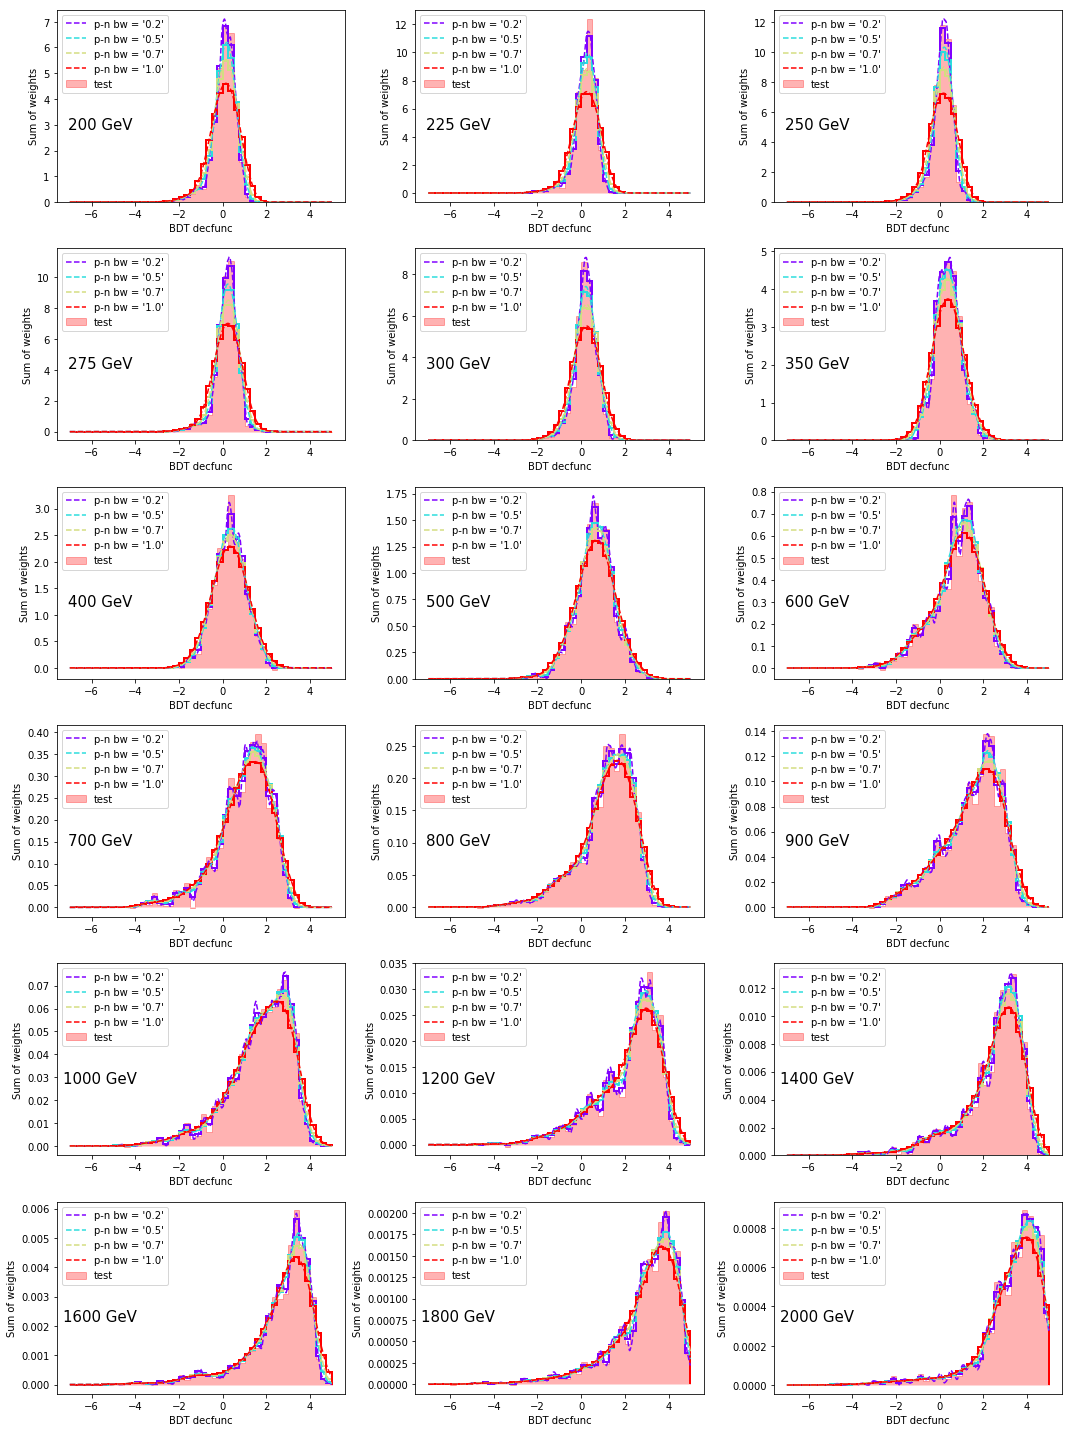

In [14]:
from sklearn.neighbors import KernelDensity
from scipy.stats import binned_statistic

fig, axes=plt.subplots(6,3, figsize=(15, 20))
bins=np.linspace(-7,5,49)
#bins=np.linspace(-7,5,13)
bincenters=[0.5*(bins[i+1]+bins[i]) for i in range(len(bins)-1)]

plotx=np.linspace(-6.995,4.995,1200)

for i,hpmass in enumerate(hpmasses):
    axis=axes[i//3][i%3]

    #binned test dataset
    testmask=(test_decfunc.realmass==hpmass) & (test_decfunc.bdttrainmass==hpmass)
    axis.hist(test_decfunc[testmask].decfunc.values, bins=bins, ls='-', histtype = 'step',label="test",color="r", fill=True, alpha=0.3, linewidth=1, weights=test_decfunc[testmask].weight.values)
    #,density=0
    
    kernel='epanechnikov'
    bandwidths=[0.2,0.5,0.7,1]
    color=iter(plt.cm.rainbow(np.linspace(0,1,len(bandwidths))))

    for bandwidth in bandwidths:
        col=next(color)
        #bandwidth=0.5
        #fit positive and negative weights independently
        kdepos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        pos_test_weights=test_decfunc[testmask & (test_decfunc.weight>0)].weight
        pos_test_values=test_decfunc[testmask & (test_decfunc.weight>0)].decfunc
        kdepos.fit(pos_test_values[:, np.newaxis],y=None,sample_weight=pos_test_weights.values)
        pos_dens = np.exp(kdepos.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, pos_dens, ':', label="kernel = '{0}'".format(kernel))

        kdeneg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
        neg_test_weights=abs(test_decfunc[testmask & (test_decfunc.weight<0)].weight)
        neg_test_values=test_decfunc[testmask & (test_decfunc.weight<0)].decfunc
        kdeneg.fit(neg_test_values[:, np.newaxis],y=None,sample_weight=neg_test_weights.values)
        neg_dens = np.exp(kdeneg.score_samples(plotx[:, np.newaxis]))
        #axis.plot(plotx, neg_dens, '--', label="neg kernel = '{0}'".format(kernel))
            
        possum=np.sum(pos_test_weights)
        negsum=np.sum(neg_test_weights)
        dx=plotx[1]-plotx[0]
        dbin=bins[1]-bins[0]
        
        final_dens=np.maximum(0.,possum*pos_dens-negsum*neg_dens)*dx
        
        axis.plot(plotx, final_dens*dbin/dx, '--', label="p-n bw = '{0:.1f}'".format(bandwidth), color=col)
        
        (stat,_,_)=binned_statistic(plotx, final_dens, statistic='sum', bins=bins)
        #axis.hist(bincenters, bins=bins, ls='-', histtype = 'step',label="p-n bw = '{0:.1f}'".format(bandwidth), color=col, fill=False, linewidth=2, weights=stat)
        axis.hist(bincenters, bins=bins, ls='-', histtype = 'step', color=col, fill=False, linewidth=2, weights=stat)

    
    axis.legend(loc=2)
    axis.set_xlabel("BDT decfunc")
    axis.set_ylabel("Sum of weights")
    axis.text(0.15, 0.4, str(hpmass)+" GeV",transform=axis.transAxes, ha="center", va="center", rotation=0, size=15)

plt.tight_layout()

let's take an epanechnikov kernel with bandwidth 0.5

## Let's evaluate a real metric

In [110]:
def plotKDE(mass, kernel="epanechnikov", bandwidth=0.5, normaliseScores=True, xaxis=np.linspace(-6.995,4.995,1200)):   
    #values with weight 0 are ignored completely, doesn't change anything anyways
    #testmask=(test_decfunc.realmass==hpmass) & (test_decfunc.bdttrainmass==hpmass)
    
    
    #TODO
    #TODO
    #TODO
    
    mask_pos=(test_decfunc.hpmass==mass) & (test_decfunc.weight>0)
    mask_neg=(test_decfunc.hpmass==mass) & (test_decfunc.weight<0)
    scores_pos=test_decfunc[mask_pos].decfunc.values.copy()
    scores_neg=test_decfunc[mask_neg].decfunc.values.copy()
    weights_pos=test_decfunc[mask_pos].weight.values.copy()
    weights_neg=test_decfunc[mask_neg].weight.values.copy()

    #first normalise the scores so that the average is 0 and the variance is 1 for all scores
    average=0.
    scale=1.
    if normaliseScores:
        average=(np.sum(scores_pos*weights_pos)+np.sum(scores_neg*weights_neg))/(np.sum(weights_pos)+np.sum(weights_neg))
        diff_pos2=np.power(scores_pos-average,2)
        diff_neg2=np.power(scores_neg-average,2)
        variance=(np.sum(diff_pos2*weights_pos)+np.sum(diff_neg2*weights_neg))/(np.sum(weights_pos)+np.sum(weights_neg))
        scale=np.sqrt(variance)
        scores_pos=(scores_pos-average)/scale
        scores_neg=(scores_neg-average)/scale
    
    #train a KDE independently for positive and negative values
    kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde_pos.fit(scores_pos[:, np.newaxis],y=None,sample_weight=weights_pos)
    kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde_neg.fit(scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(weights_neg)) #take the absolute value of the weights
    norm_pos=np.sum(weights_pos)
    norm_neg=abs(np.sum(weights_neg))
    dens = norm_pos*np.exp(kde_pos.score_samples(xaxis[:, np.newaxis]))-norm_neg*np.exp(kde_neg.score_samples(xaxis[:, np.newaxis]))
    dens=dens/np.sum(dens)
    linestyle="-"
    if mass<700:
        linestyle="--"
    plt.plot(xaxis,dens,linestyle, label=str(mass))
    #plt.plot(xaxis,np.exp(kde_neg.score_samples(xaxis[:, np.newaxis])),"--")

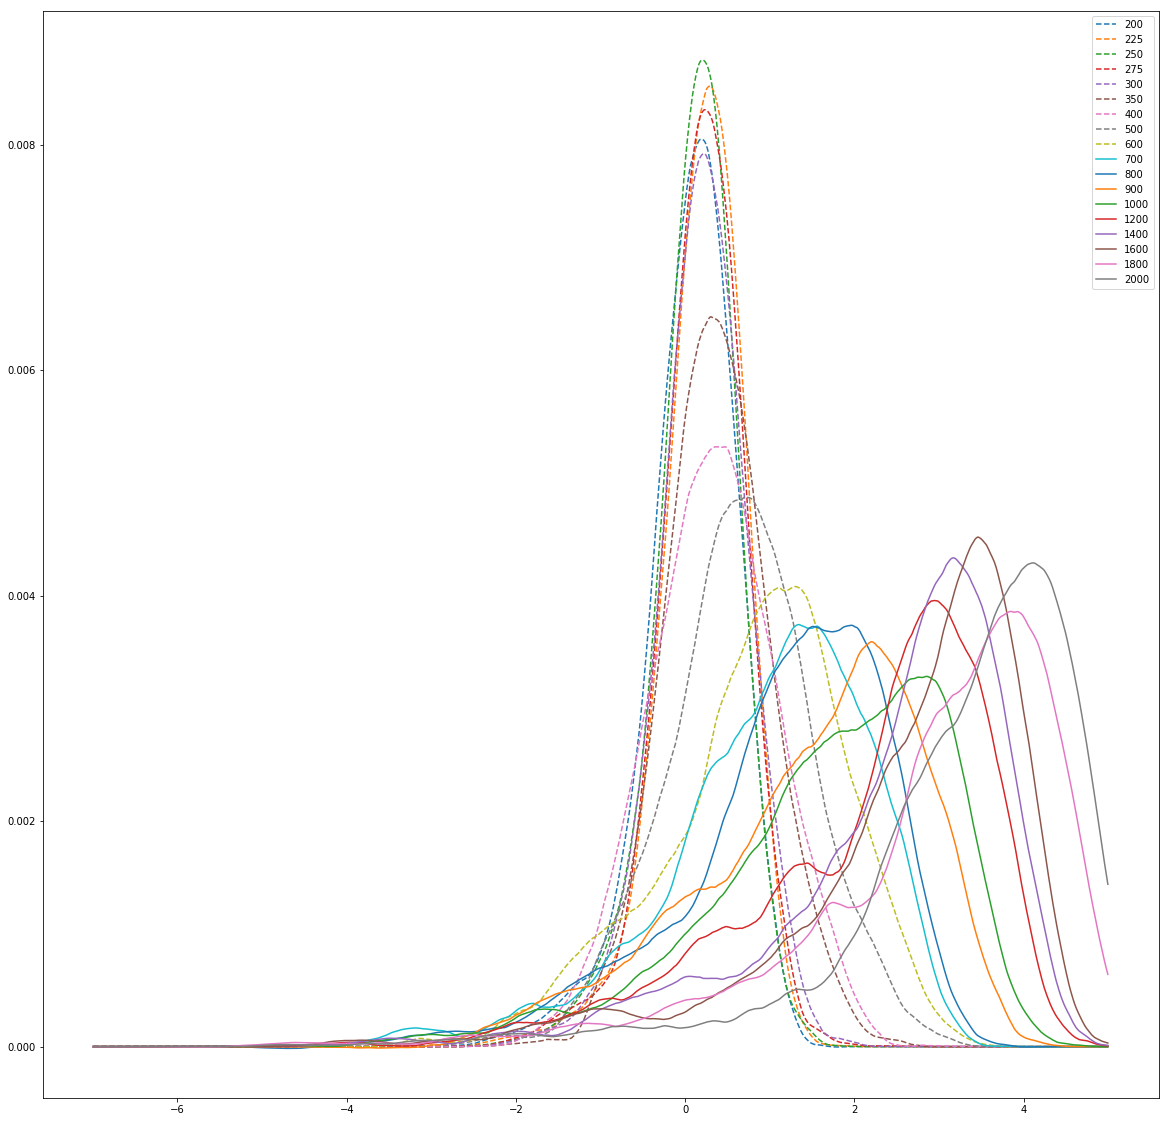

In [16]:
#a,b=interpolate(normaliseScores=False)
plt.figure(figsize=(20, 20))
for mass in hpmasses:
    plotKDE(mass, normaliseScores=False)
plt.legend()

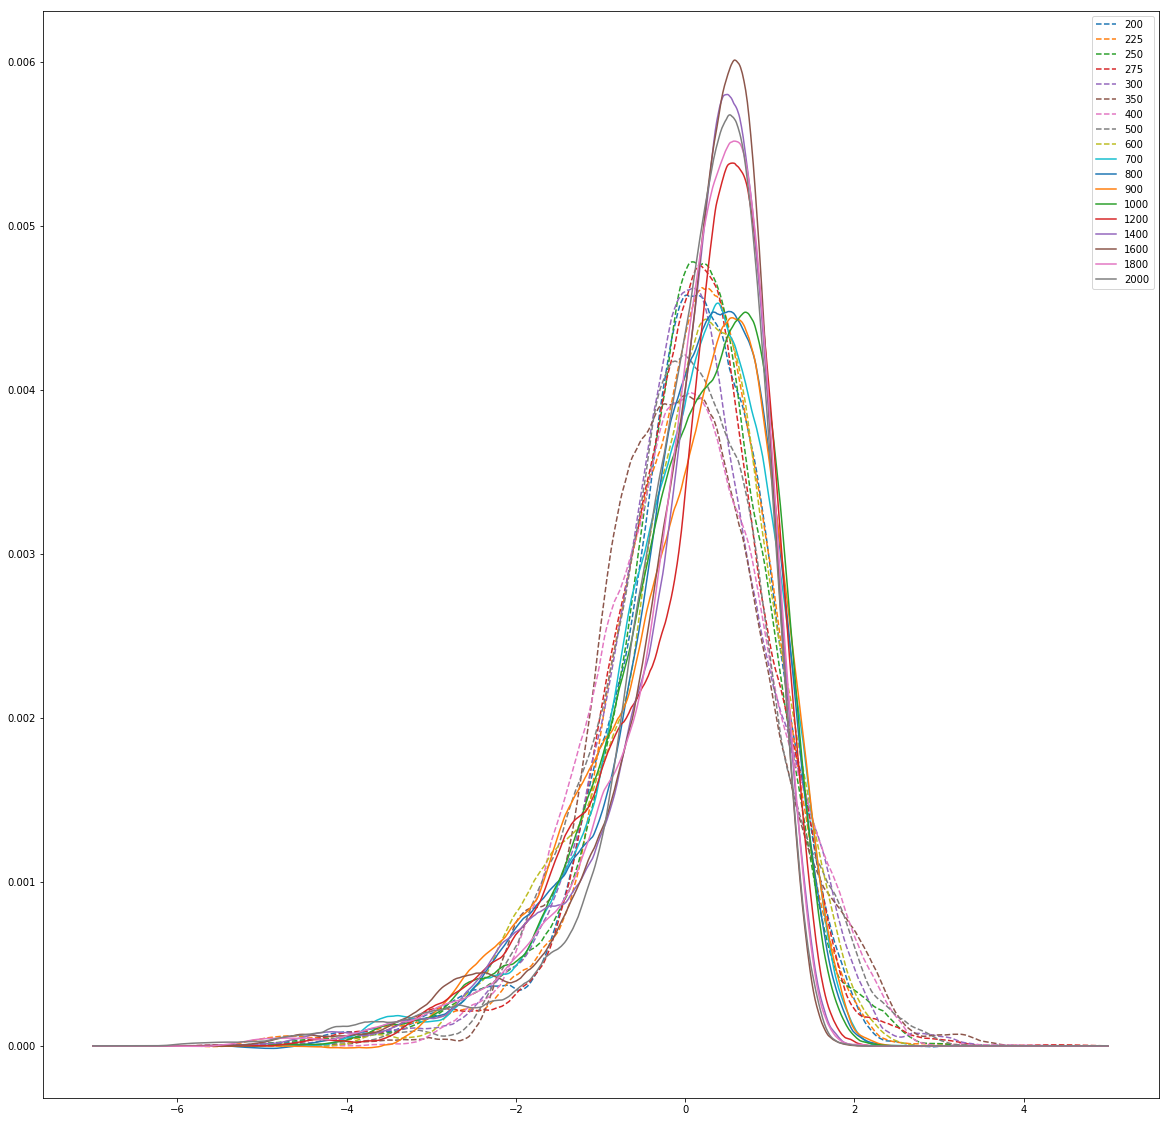

In [17]:
#a,b=interpolate(normaliseScores=True)
plt.figure(figsize=(20, 20))
for mass in hpmasses:
    plotKDE(mass, normaliseScores=True)
plt.legend()
#plotKDE(800, normaliseScores=True)

In [80]:
def interpolate(targetmass=800, mass_left=700, mass_right=900, kernel="epanechnikov", bandwidth=0.5, normaliseScores=True, draw=False, xaxis=np.linspace(-6.995,4.995,1200)):
    """ Function that interpolates a distribution """
    transformed_xaxis=np.linspace(-5,5,1000)
    
    left_weight=0.5
    right_weight=0.5
    if mass_right!=mass_left:
        left_weight=(mass_right-targetmass)/(mass_right-mass_left)
        right_weight=(targetmass-mass_left)/(mass_right-mass_left)
        
    #values with weight 0 are ignored completely, doesn't change anything anyways
    left_mask_pos=(test_decfunc.hpmass==mass_left) & (test_decfunc.weight>0)
    left_mask_neg=(test_decfunc.hpmass==mass_left) & (test_decfunc.weight<0)
    left_scores_pos=test_decfunc[left_mask_pos].decfunc.values.copy()
    left_scores_neg=test_decfunc[left_mask_neg].decfunc.values.copy()
    left_weights_pos=test_decfunc[left_mask_pos].weight.values.copy()
    left_weights_neg=test_decfunc[left_mask_neg].weight.values.copy()

    right_mask_pos=(test_decfunc.hpmass==mass_right) & (test_decfunc.weight>0)
    right_mask_neg=(test_decfunc.hpmass==mass_right) & (test_decfunc.weight<0)
    right_scores_pos=test_decfunc[right_mask_pos].decfunc.values.copy()
    right_scores_neg=test_decfunc[right_mask_neg].decfunc.values.copy()
    right_weights_pos=test_decfunc[right_mask_pos].weight.values.copy()
    right_weights_neg=test_decfunc[right_mask_neg].weight.values.copy()


    #first normalise the scores so that the average is 0 and the variance is 1 for all scores at the left of the mass
    average_left=0.
    scale_left=1.
    if normaliseScores:
        average_left=(np.sum(left_scores_pos*left_weights_pos)+np.sum(left_scores_neg*left_weights_neg))/(np.sum(left_weights_pos)+np.sum(left_weights_neg))
        diff_pos2=np.power(left_scores_pos-average_left,2)
        diff_neg2=np.power(left_scores_neg-average_left,2)
        variance_left=(np.sum(diff_pos2*left_weights_pos)+np.sum(diff_neg2*left_weights_neg))/(np.sum(left_weights_pos)+np.sum(left_weights_neg))
        scale_left=np.sqrt(variance_left)
        left_scores_pos=(left_scores_pos-average_left)/scale_left
        left_scores_neg=(left_scores_neg-average_left)/scale_left

    #first normalise the scores so that the average is 0 and the variance is 1 for all scores at the right of the mass        
    average_right=0.
    scale_right=1.
    if normaliseScores:
        average_right=(np.sum(right_scores_pos*right_weights_pos)+np.sum(right_scores_neg*right_weights_neg))/(np.sum(right_weights_pos)+np.sum(right_weights_neg))
        diff_pos2=np.power(right_scores_pos-average_right,2)
        diff_neg2=np.power(right_scores_neg-average_right,2)
        variance_right=(np.sum(diff_pos2*right_weights_pos)+np.sum(diff_neg2*right_weights_neg))/(np.sum(right_weights_pos)+np.sum(right_weights_neg))
        scale_right=np.sqrt(variance_right)
        right_scores_pos=(right_scores_pos-average_right)/scale_right
        right_scores_neg=(right_scores_neg-average_right)/scale_right
        
    #now rescale xaxis with the interpolated mean and average
    if normaliseScores:
        average_middle=(left_weight*average_left+right_weight*average_right)
        #scale_middle=(left_weight*scale_left+right_weight*scale_right)
        scale_middle=np.sqrt(left_weight*scale_left*scale_left+right_weight*scale_right*scale_right)
        #TODO: do you actually take the average scale or the average variance???
        xaxis=(xaxis-average_middle)/scale_middle
        #print("Average:", average_middle, average_left, average_right)
    
    #train a KDE independently for positive and negative values
    left_kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    left_kde_pos.fit(left_scores_pos[:, np.newaxis],y=None,sample_weight=left_weights_pos)
    left_kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    left_kde_neg.fit(left_scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(left_weights_neg)) #take the absolute value of the weights
    left_norm_pos=np.sum(left_weights_pos)
    left_norm_neg=abs(np.sum(left_weights_neg))
    left_dens=left_norm_pos*np.exp(left_kde_pos.score_samples(xaxis[:, np.newaxis]))-left_norm_neg*np.exp(left_kde_neg.score_samples(xaxis[:, np.newaxis]))
    left_dens=left_dens/np.sum(left_dens)
    if draw:
        transformed_left_dens = left_norm_pos*np.exp(left_kde_pos.score_samples(transformed_xaxis[:, np.newaxis]))-left_norm_neg*np.exp(left_kde_neg.score_samples(transformed_xaxis[:, np.newaxis]))
        transformed_left_dens=transformed_left_dens/np.sum(transformed_left_dens)
        plt.plot(transformed_xaxis,transformed_left_dens,"-", label="sum left")
    
    #train a KDE independently for positive and negative values
    right_kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    right_kde_pos.fit(right_scores_pos[:, np.newaxis],y=None,sample_weight=right_weights_pos)
    right_kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    right_kde_neg.fit(right_scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(right_weights_neg)) #take the absolute value of the weights
    right_norm_pos=np.sum(right_weights_pos)
    right_norm_neg=abs(np.sum(right_weights_neg))
    right_dens = right_norm_pos*np.exp(right_kde_pos.score_samples(xaxis[:, np.newaxis]))-right_norm_neg*np.exp(right_kde_neg.score_samples(xaxis[:, np.newaxis]))
    right_dens=right_dens/np.sum(right_dens)
    if draw:
        transformed_right_dens = right_norm_pos*np.exp(right_kde_pos.score_samples(transformed_xaxis[:, np.newaxis]))-right_norm_neg*np.exp(right_kde_neg.score_samples(transformed_xaxis[:, np.newaxis]))
        transformed_right_dens=transformed_right_dens/np.sum(transformed_right_dens)
        plt.plot(transformed_xaxis,transformed_right_dens,"-", label="sum right")
    
    
    #do the actual interpolation, i.e. a weighted sum
    middle_dens=left_weight*left_dens+right_weight*right_dens
    middle_dens=middle_dens/np.sum(middle_dens)

    if draw:
        transformed_middle_dens=left_weight*transformed_left_dens+right_weight*transformed_right_dens 
        transformed_middle_dens=transformed_middle_dens/np.sum(transformed_middle_dens)
        plt.plot(transformed_xaxis,transformed_middle_dens,"-", label="sum middle")

    return (xaxis, middle_dens)

In [19]:
def getKDE(targetmass=800, kernel="epanechnikov", bandwidth=0.5, normaliseScores=True, xaxis=np.linspace(-6.995,4.995,1200)):
    #values with weight 0 are ignored completely, doesn't change anything anyways
    mask_pos=(test_decfunc.hpmass==targetmass) & (test_decfunc.weight>0)
    mask_neg=(test_decfunc.hpmass==targetmass) & (test_decfunc.weight<0)
    scores_pos=test_decfunc[mask_pos].decfunc.values.copy()
    scores_neg=test_decfunc[mask_neg].decfunc.values.copy()
    weights_pos=test_decfunc[mask_pos].weight.values.copy()
    weights_neg=test_decfunc[mask_neg].weight.values.copy()

    #first normalise the scores so that the average is 0 and the variance is 1 for all scores
    average=0.
    scale=1.
    if normaliseScores:
        average=(np.sum(scores_pos*weights_pos)+np.sum(scores_neg*weights_neg))/(np.sum(weights_pos)+np.sum(weights_neg))
        diff_pos2=np.power(scores_pos-average,2)
        diff_neg2=np.power(scores_neg-average,2)
        variance=(np.sum(diff_pos2*weights_pos)+np.sum(diff_neg2*weights_neg))/(np.sum(weights_pos)+np.sum(weights_neg))
        scale=np.sqrt(variance)
        scores_pos=(scores_pos-average)/scale
        scores_neg=(scores_neg-average)/scale
    
    #train a KDE independently for positive and negative values
    kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde_pos.fit(scores_pos[:, np.newaxis],y=None,sample_weight=weights_pos)
    kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde_neg.fit(scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(weights_neg)) #take the absolute value of the weights
    norm_pos=np.sum(weights_pos)
    norm_neg=abs(np.sum(weights_neg))
    dens = norm_pos*np.exp(kde_pos.score_samples(xaxis[:, np.newaxis]))-norm_neg*np.exp(kde_neg.score_samples(xaxis[:, np.newaxis]))
    dens=dens/np.sum(dens)
    return dens

In [61]:
mass_left=700
mass_right=900
targetmass=800

In [84]:
def plotInterpolation(targetmass, axis=plt):
    idx=hpmasses.index(targetmass)
    mass_left=hpmasses[idx-1]
    mass_right=hpmasses[idx+1]
    xaxis=np.linspace(-6.995,4.995,1200)
    a,b=interpolate(targetmass=targetmass, mass_left=mass_left, mass_right=mass_right, draw=False,normaliseScores=True, xaxis=xaxis)
    axis.plot(xaxis,b,'-',label="interpolated")
    kd_target=getKDE(targetmass=targetmass, normaliseScores=False, xaxis=xaxis)
    axis.plot(xaxis,kd_target, '-', label="True "+str(targetmass))
    kd_left=getKDE(targetmass=mass_left, normaliseScores=False, xaxis=xaxis)
    axis.plot(xaxis,kd_left, '--', label="True "+str(mass_left))
    kd_right=getKDE(targetmass=mass_right, normaliseScores=False, xaxis=xaxis)
    axis.plot(xaxis,kd_right, '--', label="True "+str(mass_right))
    axis.legend()

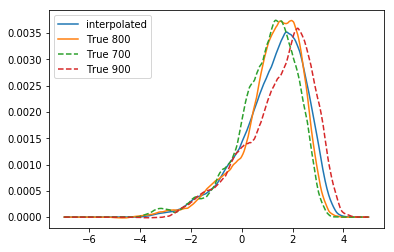

In [81]:
plotInterpolation(800)

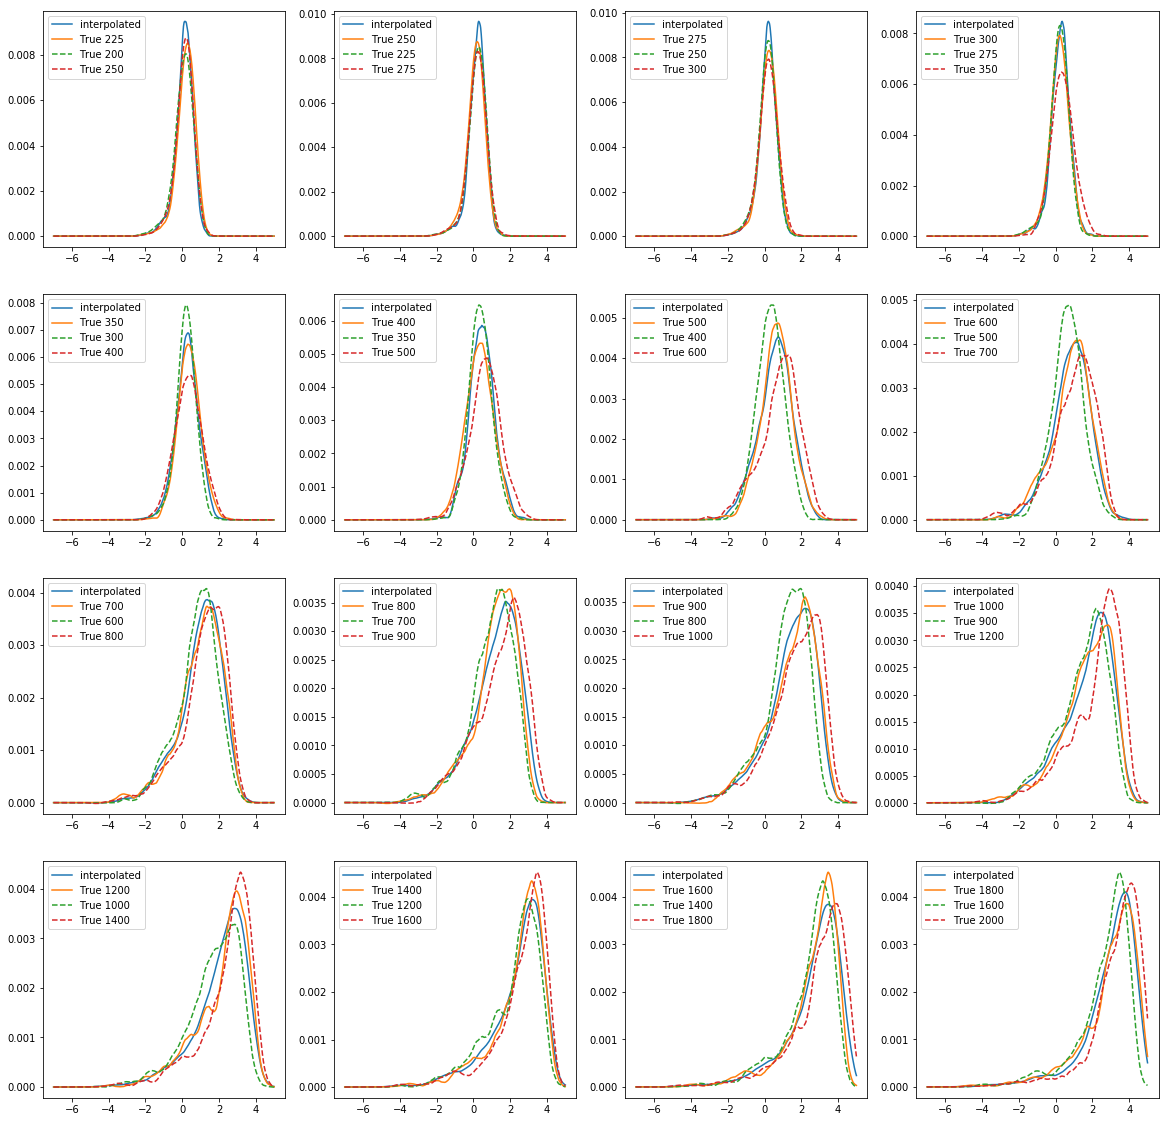

In [87]:
fig, axes=plt.subplots(4,4, figsize=(20, 20))

for i,hpmass in enumerate(hpmasses[1:-1]):
    #print(hpmass)
    axis=axes.ravel()[i]
    plotInterpolation(hpmass, axis=axis)

### now in 2D

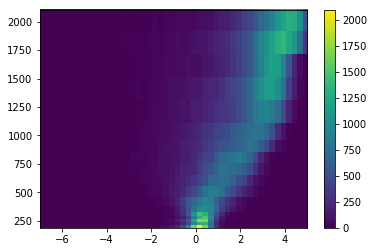

In [88]:
from sklearn.neighbors import KernelDensity
data=test_decfunc[['decfunc','hpmass']]
binsx=np.linspace(-7,5,49)
diffs=[hpmasses[i+1]-hpmasses[i] for i in range(len(hpmasses)-1)]
binsy=[hpmasses[0]-diffs[0]/2]
for i in range(len(diffs)):
    binsy.append(hpmasses[i]+diffs[i]/2)
binsy.append(hpmasses[-1]+diffs[-1]/2)
#print(binsx,binsy)

plt.figure()
plt.hist2d(test_decfunc['decfunc'].values, test_decfunc['hpmass'].values, bins=(binsx,binsy))
plt.colorbar()

# Use the mass parameterised BDT score trained at N-1 masses

In [14]:
from sklearn.neighbors import KernelDensity

def getKDE(scores, weights, kernel="epanechnikov", bandwidth=0.5, normaliseScores=True, xaxis=np.linspace(-6.995,4.995,1200)):
    #values with weight 0 are ignored completely, doesn't change anything anyways
    mask_pos=(weights>0)
    mask_neg=(weights<0)
    scores_pos=scores[mask_pos].values.copy()
    scores_neg=scores[mask_neg].values.copy()
    weights_pos=weights[mask_pos].values.copy()
    weights_neg=weights[mask_neg].values.copy()

    #first normalise the scores so that the average is 0 and the variance is 1 for all scores
    average=0.
    scale=1.
    if normaliseScores:
        average=(np.sum(scores_pos*weights_pos)+np.sum(scores_neg*weights_neg))/(np.sum(weights_pos)+np.sum(weights_neg))
        diff_pos2=np.power(scores_pos-average,2)
        diff_neg2=np.power(scores_neg-average,2)
        variance=(np.sum(diff_pos2*weights_pos)+np.sum(diff_neg2*weights_neg))/(np.sum(weights_pos)+np.sum(weights_neg))
        scale=np.sqrt(variance)
        scores_pos=(scores_pos-average)/scale
        scores_neg=(scores_neg-average)/scale
    
    #train a KDE independently for positive and negative values
    kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde_pos.fit(scores_pos[:, np.newaxis],y=None,sample_weight=weights_pos)
    kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    kde_neg.fit(scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(weights_neg)) #take the absolute value of the weights
    norm_pos=np.sum(weights_pos)
    norm_neg=abs(np.sum(weights_neg))
    dens = norm_pos*np.exp(kde_pos.score_samples(xaxis[:, np.newaxis]))-norm_neg*np.exp(kde_neg.score_samples(xaxis[:, np.newaxis]))
    dens=dens/np.sum(dens)
    return dens

In [16]:
def interpolate(targetmass, mass_left, scores_left, weights_left, mass_right, scores_right, weights_right, kernel="epanechnikov", bandwidth=0.5, normaliseScores=True, draw=False, xaxis=np.linspace(-6.995,4.995,1200)):
    """ Function that interpolates a distribution """
    
    transformed_xaxis=np.linspace(-5,5,1000)
    
    left_weight=0.5
    right_weight=0.5
    if mass_right!=mass_left:
        left_weight=(mass_right-targetmass)/(mass_right-mass_left)
        right_weight=(targetmass-mass_left)/(mass_right-mass_left)
        
    #values with weight 0 are ignored completely, doesn't change anything anyways
    left_mask_pos=(weights_left>0)
    left_mask_neg=(weights_left<0)
    left_scores_pos=scores_left[left_mask_pos].values.copy()
    left_scores_neg=scores_left[left_mask_neg].values.copy()
    left_weights_pos=weights_left[left_mask_pos].values.copy()
    left_weights_neg=weights_left[left_mask_neg].values.copy()

    right_mask_pos=(weights_right>0)
    right_mask_neg=(weights_right<0)
    right_scores_pos=scores_right[right_mask_pos].values.copy()
    right_scores_neg=scores_right[right_mask_neg].values.copy()
    right_weights_pos=weights_right[right_mask_pos].values.copy()
    right_weights_neg=weights_right[right_mask_neg].values.copy()

    #first normalise the scores so that the average is 0 and the variance is 1 for all scores at the left of the mass
    average_left=0.
    scale_left=1.
    if normaliseScores:
        average_left=(np.sum(left_scores_pos*left_weights_pos)+np.sum(left_scores_neg*left_weights_neg))/(np.sum(left_weights_pos)+np.sum(left_weights_neg))
        diff_pos2=np.power(left_scores_pos-average_left,2)
        diff_neg2=np.power(left_scores_neg-average_left,2)
        variance_left=(np.sum(diff_pos2*left_weights_pos)+np.sum(diff_neg2*left_weights_neg))/(np.sum(left_weights_pos)+np.sum(left_weights_neg))
        scale_left=np.sqrt(variance_left)
        left_scores_pos=(left_scores_pos-average_left)/scale_left
        left_scores_neg=(left_scores_neg-average_left)/scale_left

    #first normalise the scores so that the average is 0 and the variance is 1 for all scores at the right of the mass        
    average_right=0.
    scale_right=1.
    if normaliseScores:
        average_right=(np.sum(right_scores_pos*right_weights_pos)+np.sum(right_scores_neg*right_weights_neg))/(np.sum(right_weights_pos)+np.sum(right_weights_neg))
        diff_pos2=np.power(right_scores_pos-average_right,2)
        diff_neg2=np.power(right_scores_neg-average_right,2)
        variance_right=(np.sum(diff_pos2*right_weights_pos)+np.sum(diff_neg2*right_weights_neg))/(np.sum(right_weights_pos)+np.sum(right_weights_neg))
        scale_right=np.sqrt(variance_right)
        right_scores_pos=(right_scores_pos-average_right)/scale_right
        right_scores_neg=(right_scores_neg-average_right)/scale_right
        
    #now rescale xaxis with the interpolated mean and average
    if normaliseScores:
        average_middle=(left_weight*average_left+right_weight*average_right)
        #scale_middle=(left_weight*scale_left+right_weight*scale_right)
        scale_middle=np.sqrt(left_weight*scale_left*scale_left+right_weight*scale_right*scale_right)
        #TODO: do you actually take the average scale or the average variance???
        xaxis=(xaxis-average_middle)/scale_middle
        #print("Average:", average_middle, average_left, average_right)
    
    #train a KDE independently for positive and negative values
    left_kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    left_kde_pos.fit(left_scores_pos[:, np.newaxis],y=None,sample_weight=left_weights_pos)
    left_kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    left_kde_neg.fit(left_scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(left_weights_neg)) #take the absolute value of the weights
    left_norm_pos=np.sum(left_weights_pos)
    left_norm_neg=abs(np.sum(left_weights_neg))
    left_dens=left_norm_pos*np.exp(left_kde_pos.score_samples(xaxis[:, np.newaxis]))-left_norm_neg*np.exp(left_kde_neg.score_samples(xaxis[:, np.newaxis]))
    left_dens=left_dens/np.sum(left_dens)
    if draw:
        transformed_left_dens = left_norm_pos*np.exp(left_kde_pos.score_samples(transformed_xaxis[:, np.newaxis]))-left_norm_neg*np.exp(left_kde_neg.score_samples(transformed_xaxis[:, np.newaxis]))
        transformed_left_dens=transformed_left_dens/np.sum(transformed_left_dens)
        plt.plot(transformed_xaxis,transformed_left_dens,"-", label="sum left")
    
    #train a KDE independently for positive and negative values
    right_kde_pos = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    right_kde_pos.fit(right_scores_pos[:, np.newaxis],y=None,sample_weight=right_weights_pos)
    right_kde_neg = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    right_kde_neg.fit(right_scores_neg[:, np.newaxis],y=None,sample_weight=np.abs(right_weights_neg)) #take the absolute value of the weights
    right_norm_pos=np.sum(right_weights_pos)
    right_norm_neg=abs(np.sum(right_weights_neg))
    right_dens = right_norm_pos*np.exp(right_kde_pos.score_samples(xaxis[:, np.newaxis]))-right_norm_neg*np.exp(right_kde_neg.score_samples(xaxis[:, np.newaxis]))
    right_dens=right_dens/np.sum(right_dens)
    if draw:
        transformed_right_dens = right_norm_pos*np.exp(right_kde_pos.score_samples(transformed_xaxis[:, np.newaxis]))-right_norm_neg*np.exp(right_kde_neg.score_samples(transformed_xaxis[:, np.newaxis]))
        transformed_right_dens=transformed_right_dens/np.sum(transformed_right_dens)
        plt.plot(transformed_xaxis,transformed_right_dens,"-", label="sum right")
    
    
    #do the actual interpolation, i.e. a weighted sum
    middle_dens=left_weight*left_dens+right_weight*right_dens
    middle_dens=middle_dens/np.sum(middle_dens)

    if draw:
        transformed_middle_dens=left_weight*transformed_left_dens+right_weight*transformed_right_dens 
        transformed_middle_dens=transformed_middle_dens/np.sum(transformed_middle_dens)
        plt.plot(transformed_xaxis,transformed_middle_dens,"-", label="sum middle")

    return (xaxis, middle_dens)

[800] [800 700 900]
800 10 700 900


hpmass
700.0    3.909884
800.0    2.545413
900.0    1.386873
Name: weight, dtype: float64

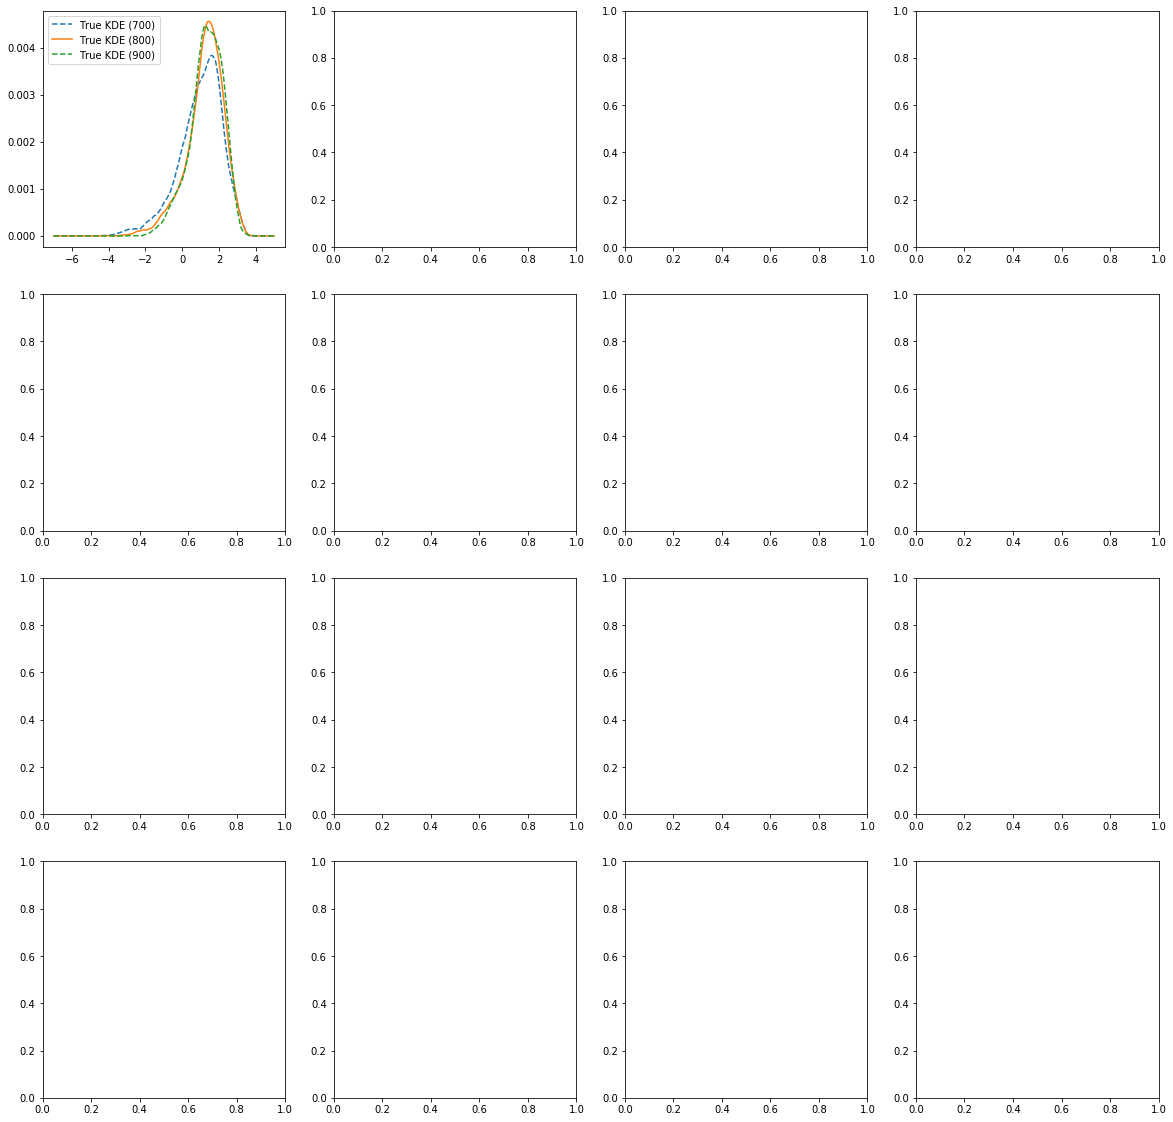

In [30]:
from joblib import load

fig, axes=plt.subplots(4,4, figsize=(20, 20))
X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval =htf.prepare(hpmass="multi", addMass=True, invertsignal=False, absoluteWeight=False)
xaxis=np.linspace(-6.995,4.995,1200)

for i,hpmass in enumerate(hpmasses[10:11]):
#for i,hpmass in enumerate(hpmasses[1:-1]):
    axis=axes.ravel()[i]
    idx=hpmasses.index(hpmass)
    mass_left=hpmasses[idx-1]
    mass_right=hpmasses[idx+1]
    
    #calculate the BDT scores
    #1. take the training at N-1 masses (i.e. all masses except hpmass)
    clf=load('massparameterisedBDT_allbut'+str(hpmass)+'.joblib') #e.g. massparameterisedBDT_allbut800.joblib

    #mask_train=(X_train.hpmass==hpmass) | (X_train.hpmass==mass_left) | (X_train.hpmass==mass_right)
    #bdtscore_train=clf.decision_function(X_train[mask_train])
    #decfunc_train=pd.concat([X_train.hpmass,pd.Series(bdtscore_train, index=X_train[mask_train].index), w_train[mask_train]],axis=1)
    #decfunc_train.columns = ['hpmass', 'decfunc','weight']
    
    mask_test=(X_test.hpmass==hpmass) | (X_test.hpmass==mass_left) | (X_test.hpmass==mass_right)
    X=X_test[mask_test].copy()
    truemass=X.hpmass.copy()
    X.hpmass=hpmass
    print(X.hpmass.unique(), truemass.unique())
    
    bdtscore_test=clf.decision_function(X)
    decfunc_test=pd.concat([truemass,pd.Series(bdtscore_test, index=X.index), w_test[mask_test]],axis=1)
    decfunc_test.columns = ['hpmass','decfunc','weight']
    
    #2. make the interpolation
    #interpolate(targetmass, mass_left, scores_left, weights_left, mass_right, scores_right, weights_right, kernel="epanechnikov", bandwidth=0.5, normaliseScores=True, draw=False, xaxis=np.linspace(-6.995,4.995,1200)):
    
    #3. get the true KDE
    for j,mass in enumerate([mass_left, hpmass, mass_right]):
        truekde=getKDE(decfunc_test.decfunc[decfunc_test.hpmass==mass], decfunc_test.weight[decfunc_test.hpmass==mass], xaxis=xaxis,normaliseScores=False)
        linestyle='-' if j%2 else '--'
        axis.plot(xaxis,truekde,linestyle, label='True KDE ('+str(mass)+')')
    axis.legend()
    
    print(hpmass, idx, mass_left, mass_right)
X.groupby(truemass).count()
w_test.groupby(truemass).count()
w_test.groupby(truemass).sum()